In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
data = np.load("../data/11-01_mapped.npy")

#### We have 1 datapoint per 10 minutes, resulting in 144 data points per day

In [86]:
data.shape

(144, 100, 100)

In [4]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

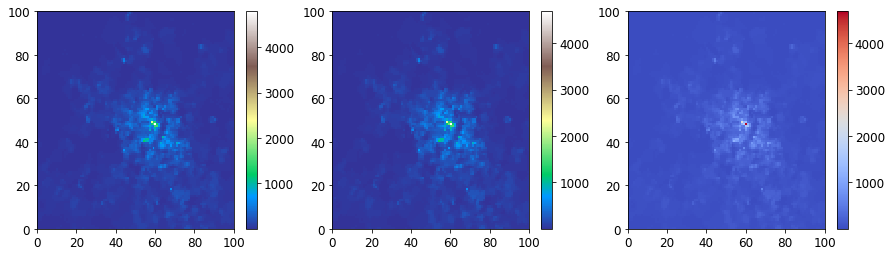

In [85]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
dots1 = data[90]
plt.pcolormesh(dots1, cmap='terrain', vmin=dots1.min(), vmax=dots1.max())
plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(dots1, cmap='terrain', vmin=dots1.min(), vmax=dots1.max() - 100)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(dots1, cmap='coolwarm', vmin=dots1.min(), vmax=dots1.max() - 100)
plt.colorbar()

# plt.subplot(1, 3, 3)
# dots2 = np.log(data[40] + 1)
# plt.pcolormesh(dots2, cmap='plasma', vmin=dots2.min(), vmax=dots2.max())
# plt.colorbar()

# plt.subplots_adjust(wspace=0.5)

plt.show()


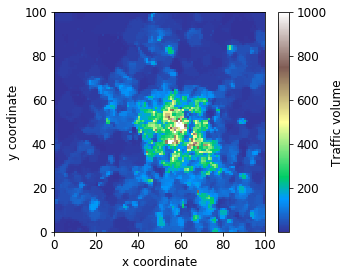

In [99]:
plt.rcParams.update({'font.size': 12})  
plt.figure(figsize=(5, 4))
dots1 = data[96]  # 15:00 UTC,  16:00 local Milan time
plt.pcolormesh(dots1, cmap='terrain', vmin=dots1.min(), vmax=1000)
plt.colorbar(label="Traffic volume")


plt.ylabel("y coordinate")
plt.xlabel("x coordinate")

plt.tight_layout()

plt.savefig("figa.pdf")


plt.show()

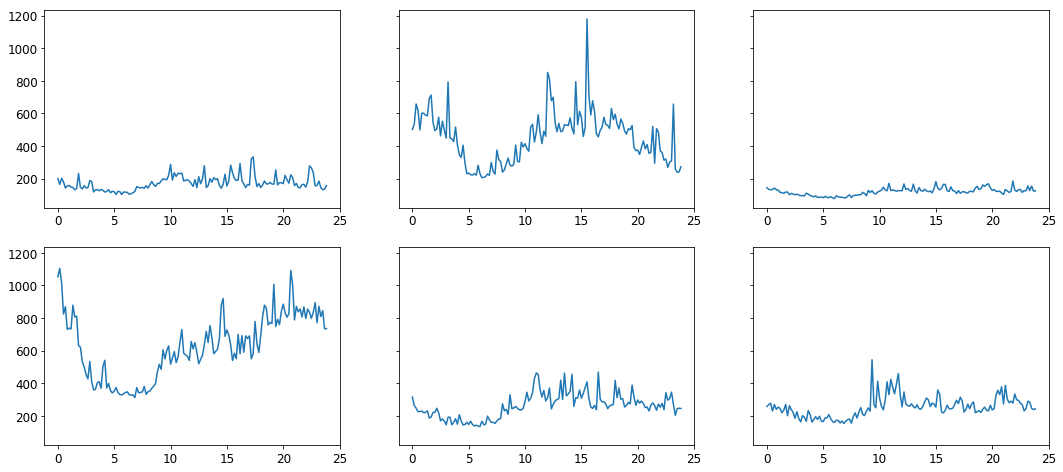

In [75]:
cell_coords = [
    [(45, 45), (50, 60), (60, 60)],
    [(55, 55), (40, 70), (51, 51)]
]
fig, axis_grid = plt.subplots(2, 3, sharey=True, figsize=(18, 8))

for line_coords, axis in zip(cell_coords, axis_grid):
    for coords, ax in zip(line_coords, axis):
        cell_data = data[:, coords[0], coords[1]]

        x_grid = np.arange(0, cell_data.shape[0] / 6, 1 / 6)

        ax.plot(x_grid, cell_data)